# NLP: Analyzing Healthcare Reviews and Predicting Their Useful Votes




In [1]:
import os
import codecs
import json
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('C:/Users/andre/Documents/yelp_dataset_challenge_round9')
businesses_filepath = os.path.join(data_directory, 'yelp_academic_dataset_business.json')
review_json_filepath = os.path.join(data_directory, 'yelp_academic_dataset_review.json')
intermediate_directory = os.path.join(data_directory, 'intermediate')
review_txt_filepath = os.path.join(intermediate_directory, 'review_text_all.txt')

In [2]:
healthcare_ids = []

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    
    # iterate through each line (json record) in the file
    for business_json in f:
        
        # convert the json record to a Python dict
        business = json.loads(business_json)
        
        # if this business has no categories or is not a target entity, skip to the next one
        if business[u'categories'] is None or u'Health & Medical' not in business[u'categories']:
            continue
        # Remove businesses in BW, Germany
        if u'BW' in business[u'state']:
            continue
        # Remove businesses that are restaurants, food and pets
        if u'Restaurants' in business[u'categories'] or u'Food' in business[u'categories'] or 'Pets' in business[u'categories']:
            continue
            
        # add the business id to our healthcare_ids set
        healthcare_ids.append(business[u'business_id'])

# Turn the list of ids into a set, which is faster for testing whether an element is in the set
healthcare_ids = set(healthcare_ids)

# print the number of unique ids in the dataset
print ('{:,}'.format(len(healthcare_ids)), u'health & medical entities in the dataset.')

10,211 health & medical entities in the dataset.


In [3]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.
    
review_count = 0
useful = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:

    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
        for review_json in review_json_file:
            review = json.loads(review_json)

            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)
            
            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r','') + '\n')
            review_count += 1
            useful.append(review[u'useful'])

print (u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 114,556 healthcare reviews written to the new txt file.


In [4]:
useful = np.array(useful)
luseful = np.log(useful+1)
df = pd.DataFrame(useful, columns=['useful'])
df.to_csv(os.path.join(intermediate_directory, 'useful.csv'))

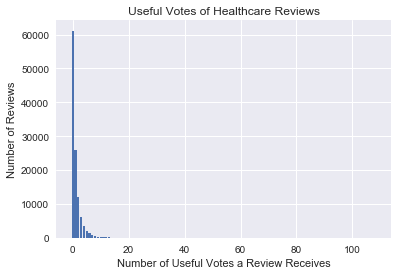

In [5]:
unique, counts = np.unique(useful, return_counts = True)
plt.bar(unique,counts)
plt.xlabel('Number of Useful Votes a Review Receives')
plt.ylabel('Number of Reviews')
plt.title('Useful Votes of Healthcare Reviews')
plt.show()

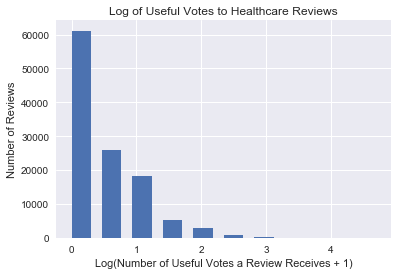

In [6]:
plt.hist(luseful, bins = 10, width = 0.3, align='mid')
plt.xlabel('Log(Number of Useful Votes a Review Receives + 1)')
plt.ylabel('Number of Reviews')
plt.title('Log of Useful Votes to Healthcare Reviews')
plt.show()

### Preprocessing the Text

I use spaCy to tokenize, lemmitize and remove stopwords from the text. Apply phrase modeling by looking for words that tend to appear one after another more frequently than by random chance.

In [7]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

In [8]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

unigram_sentences_filepath = os.path.join(intermediate_directory, 'unigram_sentences_all.txt')
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
bigram_sentences_filepath = os.path.join(intermediate_directory, 'bigram_sentences_all.txt')
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')
trigram_reviews_filepath = os.path.join(intermediate_directory, 'trigram_transformed_reviews_all.txt')

In [9]:
def punct_space(token):
    """Eliminate tokens that are pure punctuation or white space"""
    
    return token.is_punct or token.is_space

def person(token):
    """Remove tokens that are PERSON entities"""
    
    return token.ent_type_ == 'PERSON'

def line_review(filename):
    """Generator function (iterator without storing all texts)
    to read in reviews from file and return the original line breaks"""
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """Generator function to use spaCy to parse reviews, lemmatize the text and yield sentences"""
    
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent 
                             if not (punct_space(token) or person(token))])

In [10]:
# Segment reviews into sentences and normalize the text
# Save the parsed sentences file on disk to avoid storing the entire corpus in RAM
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence + '\n')

In [11]:
# gensim's LineSentence class takes the format: one sentence = one line
# words are preprocessed and separated by whitespace.
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [12]:
# Run a phrase model to link two-words phrases together
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)
bigram_model = Phrases.load(bigram_model_filepath)

In [13]:
# Apply the bigram model to unigram sentences and create a text with bigram sentences
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf-8') as f:
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + '\n')

In [14]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [15]:
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
trigram_model = Phrases.load(trigram_model_filepath)

In [16]:
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for bigram_sentence in bigram_sentences:
        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
        f.write(trigram_sentence + '\n') 

In [17]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [18]:
# Write a transformed text into a new file, with one review per line
with codecs.open(trigram_reviews_filepath, 'w', encoding='utf-8') as f:
    for parsed_review in nlp.pipe(line_review(review_txt_filepath), batch_size=10000, n_threads=4):

        # Lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review 
                          if not (punct_space(token) or person(token))]

        # Apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]

        # Remove any remaining stopwords
        trigram_review = [term for term in trigram_review 
                          if term not in spacy.en.language_data.STOP_WORDS]

        # Write the transformed review as a new line
        trigram_review = u' '.join(trigram_review)
        f.write(trigram_review + '\n')

### Train a Word2Vec Model

In [19]:
from gensim.models import Word2Vec
word2vec_filepath = os.path.join(intermediate_directory, 'word2vec_model_all')

In [20]:
# Train a word2vec model: 100-dimensional word vectors
word2vec = Word2Vec(size=100, window=5, min_count=50, sg=0, workers=4)
word2vec.build_vocab(trigram_sentences) 
word2vec.train(trigram_sentences, total_examples=word2vec.corpus_count, epochs=10)
word2vec.save(word2vec_filepath)

word2vec = Word2Vec.load(word2vec_filepath)

In [21]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(word2vec.wv.vocab)))

6,382 terms in the word2vec vocabulary.


In [22]:
# build a list of terms, index, and term counts from the word2vec model
ordered_vocab = [(term, vocab.index, vocab.count) for term, vocab in word2vec.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda ordered_vocab:ordered_vocab[2], reverse=True)
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

In [23]:
# Creat a dictionary mapping each word to a 100-dimensional vector
word_vectors = dict(list(zip(word2vec.wv.index2word, word2vec.wv.syn0)))

In [24]:
word2vec.most_similar(positive=['dentist'], topn=5)

[('pediatric_dentist', 0.7773758172988892),
 ('orthodontist', 0.7484958171844482),
 ('dermatologist', 0.7320617437362671),
 ('pediatrician', 0.7221524715423584),
 ('gynecologist', 0.703641414642334)]

In [25]:
word2vec.most_similar(positive=['dentist', 'baby'], negative=['tooth'],topn=5)

[('pediatrician', 0.662972092628479),
 ('doctor', 0.6485235691070557),
 ('ob', 0.6412153840065002),
 ('doc', 0.6246420741081238),
 ('dr', 0.6178021430969238)]

### Training a Doc2Vec Model

In [26]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')

In [28]:
X = []
with codecs.open(trigram_reviews_filepath, encoding='utf-8') as f:
    for review in f:
        X.append(review)

labels = ['Review_' + str(x) for x in range(len(X))]

In [29]:
class DocIterator():
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(), tags=[self.labels_list[idx]])

In [30]:
labeled_reviews = DocIterator(X, labels)

In [31]:
# To produce better results, iterate over the data 10 times
# and control the learning rate for each iteration
doc2vec = Doc2Vec(size=100, window=5, min_count=50, workers=4, iter=10)
doc2vec.build_vocab(labeled_reviews)

doc2vec.train(labeled_reviews, total_examples=doc2vec.corpus_count, epochs=10)

doc2vec.save(doc2vec_filepath)
doc2vec.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
doc2vec = Doc2Vec.load(doc2vec_filepath)

In [32]:
doc2vec.most_similar(positive=["pediatrician"], topn=5)

[('obgyn', 0.6879574060440063),
 ('ped', 0.6675028800964355),
 ('gp', 0.6644524335861206),
 ('ob', 0.6589359045028687),
 ('pcp', 0.6388132572174072)]

In [33]:
doc2vec.most_similar(positive=['pediatrician','tooth'], negative=['baby'], topn=5)

[('dentist', 0.5935369729995728),
 ('pediatric_dentist', 0.5770177841186523),
 ('orthodontist', 0.5411350727081299),
 ('teeth', 0.5282765626907349),
 ('periodontist', 0.5172334909439087)]

In [34]:
doc2vec.docvecs.most_similar('Review_10', topn=5)

[('Review_28770', 0.7332645058631897),
 ('Review_55797', 0.7231159210205078),
 ('Review_77575', 0.7128130197525024),
 ('Review_33470', 0.7096557021141052),
 ('Review_55802', 0.709504246711731)]